In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import sys
import tensorflow as tf
import tqdm
from typing import List, Sequence
sys.path.append("../")

from symphony.data import input_pipeline_tf

run `fragments.py` first

In [2]:
with open("../target_counts.pkl", "rb") as f:
    num_atoms = pickle.load(f)

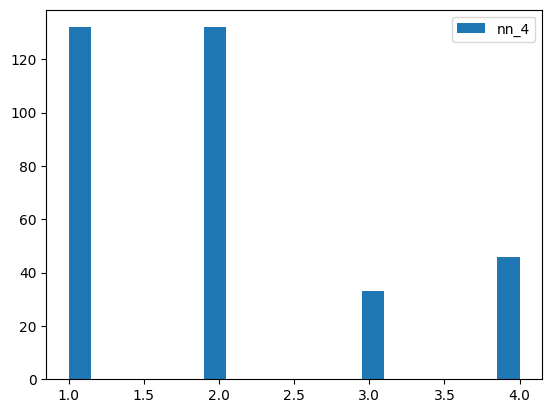

In [3]:
for model, data in num_atoms.items():
    plt.hist(x=data, label=model, bins=20)
plt.legend()
plt.show()